# Configuration

In [30]:
%load_ext autoreload
%autoreload 2

## Read packages

In [66]:
import json, math, random, time, zipfile, io
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional
import copy

from types import SimpleNamespace
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from torchvision import transforms, models
from torchsummary import summary

from torchmetrics.classification import BinaryAccuracy

import albumentations as A
from albumentations.pytorch import ToTensorV2


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

import os
import sys

sys.path.append("..")

from src.data_utils import *
from src.cnn_models import *
from src.training_utils import *
from src.evaluation_utils import *

Device: cpu


## Read data-images

In [32]:
filename = "cnn_personalized.ipynb"  # Name of current file
print(f"Current absolute path: {os.getcwd()}\n")

# We specify the path of the current directory and the data and output directories.
ACTUAL_DIR = os.path.dirname(os.path.abspath(filename))
BASE_DIR = os.path.dirname(ACTUAL_DIR)
DATA_DIR = os.path.join(BASE_DIR, "data")
IMG_DIR = os.path.join(DATA_DIR, "images")
OUTPUT_DIR = os.path.join(DATA_DIR, "output")

print(f"BASE_DIR: {BASE_DIR}")
print(f"DATA_DIR: {DATA_DIR}")
print(f"IMG_DIR: {IMG_DIR}")
print(f"OUTPUT_DIR: {OUTPUT_DIR}")

Current absolute path: /Users/jhonattan.reales/Library/Mobile Documents/com~apple~CloudDocs/MAESTRIA MIAA 2025-2026/Cursos semestres/SEMESTRE 2/Aprendizaje automatico IV/Competencia-CNN/Kaggle_CNN_competition_ML4_MIAA/notebooks

BASE_DIR: /Users/jhonattan.reales/Library/Mobile Documents/com~apple~CloudDocs/MAESTRIA MIAA 2025-2026/Cursos semestres/SEMESTRE 2/Aprendizaje automatico IV/Competencia-CNN/Kaggle_CNN_competition_ML4_MIAA
DATA_DIR: /Users/jhonattan.reales/Library/Mobile Documents/com~apple~CloudDocs/MAESTRIA MIAA 2025-2026/Cursos semestres/SEMESTRE 2/Aprendizaje automatico IV/Competencia-CNN/Kaggle_CNN_competition_ML4_MIAA/data
IMG_DIR: /Users/jhonattan.reales/Library/Mobile Documents/com~apple~CloudDocs/MAESTRIA MIAA 2025-2026/Cursos semestres/SEMESTRE 2/Aprendizaje automatico IV/Competencia-CNN/Kaggle_CNN_competition_ML4_MIAA/data/images
OUTPUT_DIR: /Users/jhonattan.reales/Library/Mobile Documents/com~apple~CloudDocs/MAESTRIA MIAA 2025-2026/Cursos semestres/SEMESTRE 2/Aprendi

In [33]:
# Read the CSV file
csv_file = os.path.join(DATA_DIR, "train.csv")
df_train_complete = pd.read_csv(csv_file)

## Init params
Base parameters to use downstream.

In [34]:
# Data related params
prct_train = 0.85
img_size = 256
batch_size = 32
weight_cap = 5  # for positive weight, to avoid too large weights

### Base CNN ###
# Base CNN architecture params
base_ch = 16
out_dim = 128
base_dropout = 0.3

# Base training params
lr_base = 1e-4
weight_decay_base = 1e-4

# Prepare data
Divide train and valid data.  
Build the dataloaders.

In [35]:
# Compute the weight of positive classes.
# This will be useful whether the df is desbalanced
# and for downstream training tasks

# Use a weight cap to avoid too large weights

if DEFAULT_COLS["class"] in df_train_complete.columns:
    # Calculate class counts
    counts = (
        df_train_complete[DEFAULT_COLS["class"]]
        .str.lower()
        .map(CLASS_TO_LABEL)
        .value_counts()
    )
    print("Class counts:", counts.to_dict())

    # Calculate pos_weight
    pos = float(counts.get(1, 1.0))
    neg = float(counts.get(0, 1.0))
    positive_weight = torch.tensor(
        [min(weight_cap, max(1.0, neg / max(1.0, pos)))], device=DEVICE
    )
    print("Calculated positive_weight:", positive_weight.item())
else:
    print(
        "Warning: 'class' column not found in DataFrame. Skipping pos_weight calculation."
    )

Class counts: {0: 135, 1: 84}
Calculated positive_weight: 1.6071428060531616


In [36]:
# split the data into train and valid
n = len(df_train_complete)
n_train = math.floor(prct_train * n)
n_valid = n - n_train

# Shuffle and split
df_shuffled = df_train_complete.sample(frac=1, random_state=42).reset_index(drop=True)
df_valid = df_shuffled.iloc[n_train:].reset_index(drop=True)
df_train = df_shuffled.iloc[:n_train].reset_index(drop=True)

print(f"Total samples: {n}, Train samples: {n_train}, Valid samples: {n_valid}")

Total samples: 219, Train samples: 186, Valid samples: 33


In [37]:
## Build the Datasets and Dataloaders
# In this case, we will use personalized normalization

# Compute the mean and std per channel (R, G, B) across all training images
mean_train_images, std_train_images = compute_mean_std_image_dir(
    IMG_DIR, df_train["filename"].tolist()
)

# Create the datasets with personalized normalization
train_dataset = MaskDataset(
    df=df_train,
    images_dir=IMG_DIR,
    img_size=img_size,
    personalized_norm=True,
    custom_mean=mean_train_images,
    custom_std=std_train_images,
)

# Use the same normalization of training to avoid data leakage
valid_dataset = MaskDataset(
    df=df_valid,
    images_dir=IMG_DIR,
    img_size=img_size,
    personalized_norm=True,
    custom_mean=mean_train_images,
    custom_std=std_train_images,
)

# Create the dataloaders
num_workers = max(
    4, int(os.cpu_count() / 2)
)  # Use half of the available CPU cores, at least 4

dl_train = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=(DEVICE == "cuda"),
    persistent_workers=(num_workers > 0),
    prefetch_factor=2,
)
dl_valid = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=(DEVICE == "cuda"),
    persistent_workers=(num_workers > 0),
    prefetch_factor=2,
)

# Base CNN 
Evaluate a basic backbone + basic decision head.  

In [61]:
# Instantiate the base model
base_backbone = BaseBackbone(base_ch=base_ch, out_dim=out_dim)

# Wrap the backbone and add the decision head
base_cnn_arch = TwoHeadNetVOC(
    backbone=base_backbone, feat_dim=out_dim, dropout=base_dropout
).to(DEVICE)

# Define the optimizer and the accuracy metric
optimizer = torch.optim.AdamW(
    base_cnn_arch.parameters(), lr=lr_base, weight_decay=weight_decay_base
)
acc_metric = BinaryAccuracy().to(DEVICE)

# Model summary
summary(base_cnn_arch, (3, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
              ReLU-2         [-1, 16, 128, 128]               0
            Conv2d-3           [-1, 32, 64, 64]           4,640
              ReLU-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 32, 32]          18,496
              ReLU-6           [-1, 64, 32, 32]               0
 AdaptiveAvgPool2d-7             [-1, 64, 1, 1]               0
            Linear-8                  [-1, 128]           8,320
      BaseBackbone-9                  [-1, 128]               0
           Linear-10                   [-1, 64]           8,256
             ReLU-11                   [-1, 64]               0
          Dropout-12                   [-1, 64]               0
           Linear-13                    [-1, 1]              65
           Linear-14                   

In [72]:
# Define the configuration dictionary
cfg = {
    "epochs": 10,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "es_patience": 3,
    "cls_loss_w": 1.0,  # weight for classification loss
    "box_loss_w": 1.0,  # weight for box regression loss
    "beta_smoothl1": 1.0,
    "monitor": "val_score",  # options: "val_loss", "val_iou", "val_score"
    "alpha_score": 0.6,  # weight for IoU vs ACC
    "img_size": img_size,  # image size
    "positive_weight": positive_weight,
    "acc_metric": acc_metric,
    "cnn_name": "cnn_base",
    "output_dir": OUTPUT_DIR,
    "logging_step": 5,  # log every n steps
    "norm_mean": mean_train_images,  # for personalized normalization
    "norm_std": std_train_images,  # for personalized normalization
}

# Instantiate the trainer
base_model = Trainer_base(
    base_cnn_arch,
    dl_train=dl_train,
    dl_valid=dl_valid,
    optimizer=optimizer,
    cfg=SimpleNamespace(**cfg),
    device=DEVICE,
)

# Start the training
history_base_model = base_model.fit()

Epoch 001 | LR 1.00e-04 | Train -- loss: 1.1490, acc: 0.667, IoU: 0.326 | Valid -- loss: 1.1118, acc: 0.515, IoU: 0.449 | Monitor(val_score): 0.4754
Epoch 005 | LR 1.00e-04 | Train -- loss: 1.1422, acc: 0.656, IoU: 0.319 | Valid -- loss: 1.0985, acc: 0.667, IoU: 0.449 | Monitor(val_score): 0.5361
Epoch 010 | LR 1.00e-04 | Train -- loss: 1.1281, acc: 0.688, IoU: 0.316 | Valid -- loss: 1.0881, acc: 0.667, IoU: 0.456 | Monitor(val_score): 0.5402


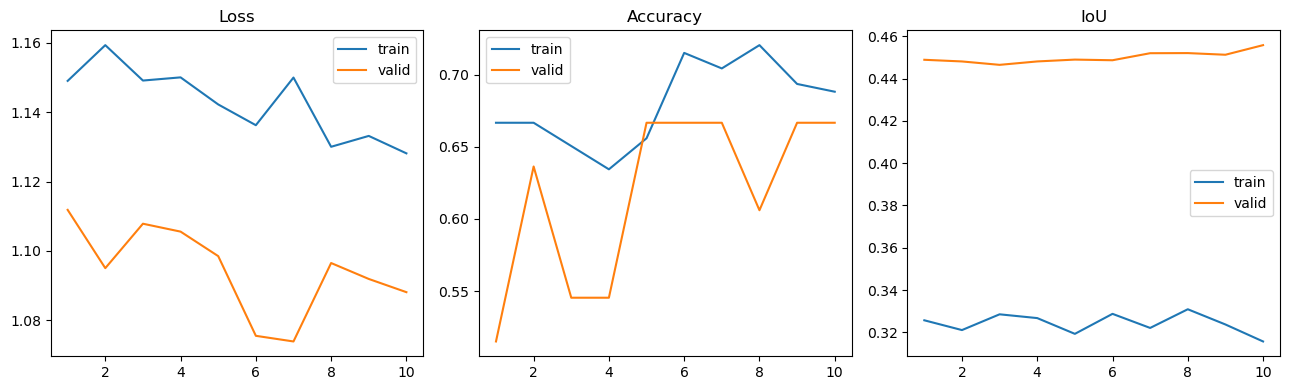

In [73]:
# Plot the training history
plot_history(history_base_model, figsize=(13, 4))

Targets [0,1] min/max/mean: (0.0, 0.99609375, 0.48330074548721313)
Preds   [0,1] min/max/mean: (0.11119875311851501, 0.8926951289176941, 0.4819009304046631)
IoU mean (batch): 0.292915569892898



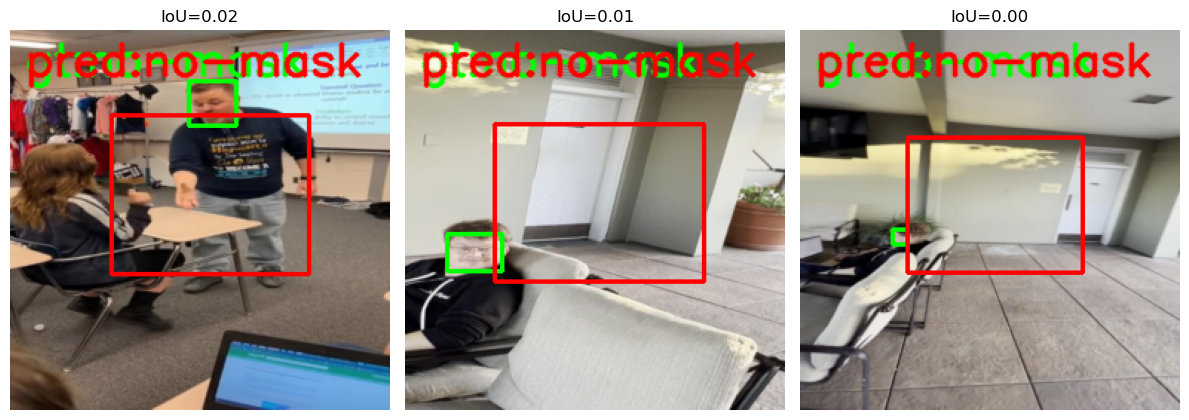

In [82]:
# Sanity check of the predictions and show some examples
sanity_check_batch(base_model)
print()

checkpoint_path = os.path.join(OUTPUT_DIR, "cnn_base", "best_monitor_model.pt")

visualize_predictions(
    model_class=base_cnn_arch,  # tu clase de red
    checkpoint_path=checkpoint_path,  # ruta al .pt
    dl_valid=dl_valid,  # tu dataloader de validación
    n_images=3,  # número de imágenes a mostrar
    n_cols=3,  # número de columnas en la grilla
    threshold=0.5,  # umbral de clasificación (opcional)
    device=DEVICE,  # o "cpu" si no tienes GPU
)

# Tunning the base model

## Improve the backbone architecture
Add more hidden layers and useful modules

## Improve the desicion head architecture
Add more layers or useful modules

## Hiperparameter tunning
Test the results by tunning different values of hiperparameters:
- d
- d

## Test Data augmentations
Use different data augmentation techniques and identify those who are better to improve the performance.

# Compare the results
Show the metrics of the different models and compare the predictions on the images (validation data)

# Conclusions

----

In [ ]:
# # Ejemplo

# backbone = BaseBackbone()

# # Add an extra conv layer at the end of self.body
# extra_layer = nn.Sequential(
#     nn.Conv2d(4*32, 8*32, 3, 1, 1),
#     nn.BatchNorm2d(8*32),
#     nn.ReLU(inplace=True),
# )

# # Concatenate to the existing body
# backbone.body = nn.Sequential(
#     *(list(backbone.body.children()) + list(extra_layer.children()))
# )

In [ ]:
# # ejemplo

# backbone = BaseBackbone()

# # Replace projection with a deeper MLP
# backbone.proj = nn.Sequential(
#     backbone.proj,                      # original linear layer
#     nn.ReLU(inplace=True),
#     nn.Linear(backbone.proj.out_features, 256),  # new layer
# )